<a href="https://colab.research.google.com/github/Muzzamal-Hameed/Deep-Learning-Models/blob/main/Fish_Detection_using_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive

In [2]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [7]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [8]:
! cp kaggle.json ~/.kaggle/

In [9]:
! chmod 600 ~/.kaggle/kaggle.json

In [10]:
! kaggle datasets download -d crowww/a-large-scale-fish-dataset

100% 3.24G/3.24G [00:52<00:00, 50.3MB/s]
100% 3.24G/3.24G [00:53<00:00, 65.7MB/s]


In [11]:
! unzip a-large-scale-fish-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00435.png  
  inflating: Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00436.png  
  inflating: Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00437.png  
  inflating: Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00438.png  
  inflating: Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00439.png  
  inflating: Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00440.png  
  inflating: Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00441.png  
  inflating: Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00442.png  
  inflating: Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00443.png  
  inflating: Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00444.png  
  inflating: Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00445.png  
  inflating: Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00446.png  
  inflating: Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00447.png  
  inflating: Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00448.png  
  inflating: Fish_Dataset/Fish_Dataset/

In [12]:
import numpy as np 
import pandas as pd
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Activation
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.applications.resnet import preprocess_input
from keras_preprocessing.image import ImageDataGenerator
import os.path
from IPython.display import Image, display
import matplotlib.cm as cm
from sklearn.metrics import classification_report
import inspect

In [13]:
import sys
dir = Path('/content/Fish_Dataset/Fish_Dataset')

# list of all filepathes
filepaths = list(dir.glob(r'**/*.png'))

# list of labels extracted from last foldername of filepath
labels = list(map(lambda l: os.path.split(os.path.split(l)[0])[1], filepaths))

# series of string filepathes
filepaths = pd.Series(filepaths, name='FilePaths').astype(str)

# series of string labels
labels = pd.Series(labels, name='Labels').astype(str)

# merge series to dataframe df
df = pd.merge(filepaths, labels, right_index=True, left_index=True)

# filter folders with GT (Ground Truth) at the end
df = df[df['Labels'].apply(lambda l: l[-2:] != 'GT')]

# resampling complete rows and reset the index
df = df.sample(frac=1).reset_index(drop=True)


In [14]:
df.head()

,FilePaths,Labels
0,/content/Fish_Dataset/Fish_Dataset/Shrimp/Shri...,Shrimp
1,/content/Fish_Dataset/Fish_Dataset/Hourse Mack...,Hourse Mackerel
2,/content/Fish_Dataset/Fish_Dataset/Striped Red...,Striped Red Mullet
3,/content/Fish_Dataset/Fish_Dataset/Sea Bass/Se...,Sea Bass
4,/content/Fish_Dataset/Fish_Dataset/Hourse Mack...,Hourse Mackerel


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   FilePaths  9000 non-null   object
 1   Labels     9000 non-null   object
dtypes: object(2)
memory usage: 140.8+ KB


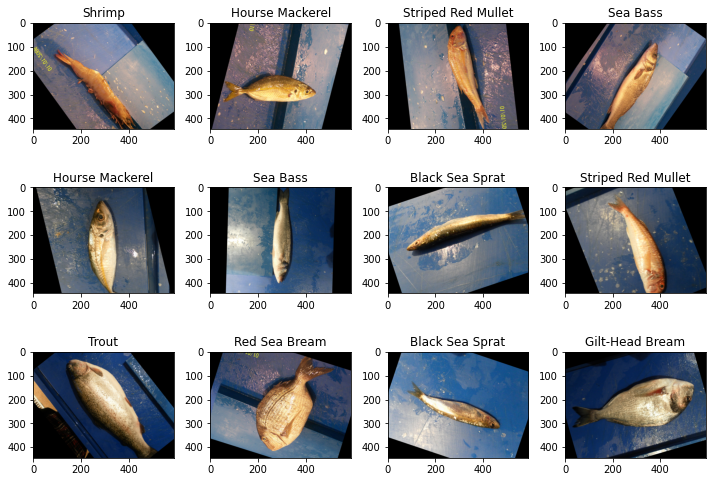

In [16]:
fit, ax = plt.subplots(nrows=3, ncols=4, figsize=(10, 7))

for i, a in enumerate(ax.flat):
    a.imshow(plt.imread(df.FilePaths[i]))
    a.set_title(df.Labels[i])
    
plt.tight_layout()
plt.show()

In [17]:
# stratisfied train and test (10%) datasets
X_train, X_test = train_test_split(df, test_size=0.1, stratify=df['Labels'])

print('Shape of Train Data: ', X_train.shape)
print('Shape of Test Data: ', X_test.shape)

# stratisfied train and val (20%) datasets
X_train, X_val = train_test_split(X_train, test_size=0.1, stratify=X_train['Labels'])

print('Shape of Train Data: ', X_train.shape)
print('Shape of Val Data: ', X_val.shape)

# ordered count of rows per unique label
X_train['Labels'].value_counts(ascending=True)

Shape of Train Data:  (8100, 2)
Shape of Test Data:  (900, 2)
Shape of Train Data:  (7290, 2)
Shape of Val Data:  (810, 2)


Gilt-Head Bream       810
Striped Red Mullet    810
Red Sea Bream         810
Hourse Mackerel       810
Sea Bass              810
Trout                 810
Red Mullet            810
Shrimp                810
Black Sea Sprat       810
Name: Labels, dtype: int64

In [18]:
# number of samples/images per iteration
BATCH_SIZE = 32
# input image size
IMG_SIZE = (224, 224)

# image preprocessing
img_data_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

X_train = img_data_gen.flow_from_dataframe(dataframe=X_train,
                                          x_col='FilePaths',
                                          y_col='Labels',
                                          target_size=IMG_SIZE,
                                          color_mode='rgb',
                                          class_mode='categorical',
                                          batch_size=BATCH_SIZE,
                                          seed=42)

X_val = img_data_gen.flow_from_dataframe(dataframe=X_val,
                                          x_col='FilePaths',
                                          y_col='Labels',
                                          target_size=IMG_SIZE,
                                          color_mode='rgb',
                                          class_mode='categorical',
                                          batch_size=BATCH_SIZE,
                                          seed=42)

X_test = img_data_gen.flow_from_dataframe(dataframe=X_test,
                                          x_col='FilePaths',
                                          y_col='Labels',
                                          target_size=IMG_SIZE,
                                          color_mode='rgb',
                                          class_mode='categorical',
                                          batch_size=BATCH_SIZE,
                                          seed=42)

Found 7290 validated image filenames belonging to 9 classes.
Found 810 validated image filenames belonging to 9 classes.
Found 900 validated image filenames belonging to 9 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input dat

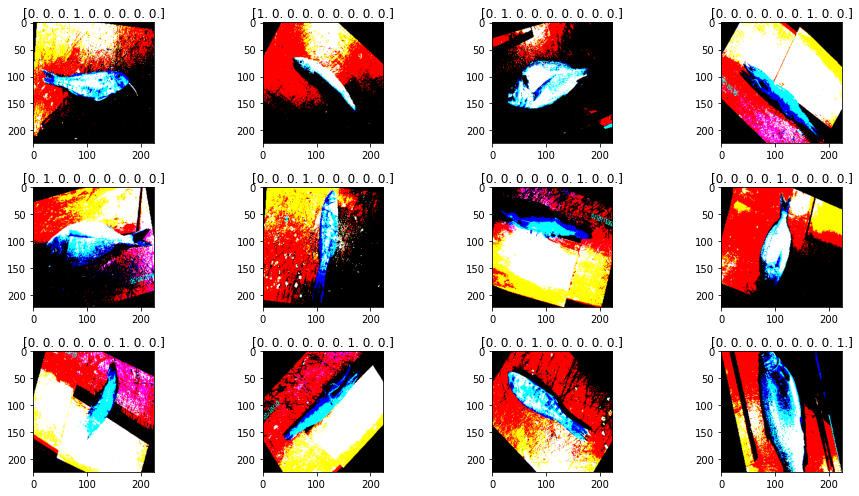

In [19]:
fit, ax = plt.subplots(nrows=3, ncols=4, figsize=(13,7))

for i, a in enumerate(ax.flat):
    img, label = X_train.next()
    a.imshow(img[0],)
    a.set_title(label[0])

plt.tight_layout()
plt.show()

In [23]:
model = Sequential()
# scale image values to 0..1
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255))

# 1. Conv2D layer
model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', input_shape=(224, 224, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'))

# 2. Conv2D layer
model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'))

# 3. Conv2D layer
model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'))

# 4. Conv2D layer
model.add(Conv2D(filters=256, kernel_size=(3,3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'))

# scale to 1 dimensional input for NN
model.add(Flatten())

# hidden fully connected layer
model.add(Dense(512))
model.add(Activation('relu'))

# inhibit overfitting
model.add(Dropout(0.1))

# output fully connected layer
model.add(Dense(9))
model.add(Activation('softmax'))

# compile model
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [24]:
# stop training when accuracy has stopped improving 
cb = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=5)
# train model 
hst = model.fit(X_train, validation_data=X_val, epochs=10, callbacks=cb)

Epoch 1/10
228/228 [==============================] - 903s 4s/step - loss: 0.9764 - accuracy: 0.6538 - val_loss: 0.5412 - val_accuracy: 0.8049
Epoch 2/10
228/228 [==============================] - 889s 4s/step - loss: 0.1747 - accuracy: 0.9395 - val_loss: 0.1230 - val_accuracy: 0.9519
Epoch 3/10
228/228 [==============================] - 887s 4s/step - loss: 0.0461 - accuracy: 0.9852 - val_loss: 0.0346 - val_accuracy: 0.9877
Epoch 4/10
228/228 [==============================] - 888s 4s/step - loss: 0.0610 - accuracy: 0.9798 - val_loss: 0.0942 - val_accuracy: 0.9716
Epoch 5/10
228/228 [==============================] - 887s 4s/step - loss: 0.0417 - accuracy: 0.9848 - val_loss: 0.0603 - val_accuracy: 0.9790
Epoch 6/10
228/228 [==============================] - 887s 4s/step - loss: 0.0223 - accuracy: 0.9936 - val_loss: 0.0350 - val_accuracy: 0.9864
Epoch 7/10
228/228 [==============================] - 887s 4s/step - loss: 0.0552 - accuracy: 0.9833 - val_loss: 0.4287 - val_accuracy: 0.8790

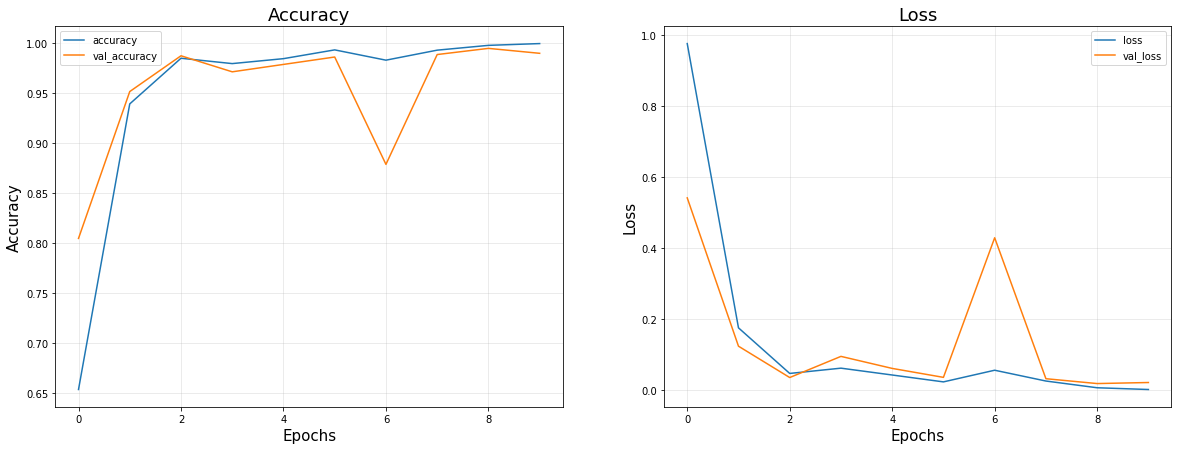

In [25]:
# Summarize the training process
fig = plt.figure(figsize=(20,7))
fig.add_subplot(121)

# Accuracy
plt.plot(hst.epoch, hst.history['accuracy'], label = "accuracy")
plt.plot(hst.epoch, hst.history['val_accuracy'], label = "val_accuracy")

plt.title("Accuracy", fontsize=18)
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("Accuracy", fontsize=15)
plt.grid(alpha=0.3)
plt.legend()


#Adding Subplot 1 (For Loss)
fig.add_subplot(122)

plt.plot(hst.epoch, hst.history['loss'], label="loss")
plt.plot(hst.epoch, hst.history['val_loss'], label="val_loss")

plt.title("Loss", fontsize=18)
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.grid(alpha=0.3)
plt.legend()

plt.show()

In [26]:
res = model.evaluate(X_test)

29/29 [==============================] - 34s 1s/step - loss: 0.0312 - accuracy: 0.9911


In [27]:
print(f'Train Accuracy: {hst.history["accuracy"][-1:][0] * 100:.2f}')
print(f'Val Accuracy: {hst.history["val_accuracy"][-1:][0] * 100:.2f}')
print(f'Test Accuracy: {res[1] * 100:.2f}')

Train Accuracy: 99.99
Val Accuracy: 99.01
Test Accuracy: 99.11


In [29]:
# Map the label
labels = (X_test.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in res]

#
cnn_model_test_acc = model.evaluate(X_test)[1]
cnn_model_val_acc = model.evaluate(X_val)[1]

#
y_test = list(test_data.Label)
print(classification_report(y_test, pred))

KeyError: ignored

In [34]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, None, None, None)  0         
                                                                 
 conv2d_4 (Conv2D)           (None, None, None, 32)    896       
                                                                 
 activation_6 (Activation)   (None, None, None, 32)    0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, None, None, 32)   0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, None, None, 64)    18496     
                                                                 
 activation_7 (Activation)   (None, None, None, 64)    0         
                                                      

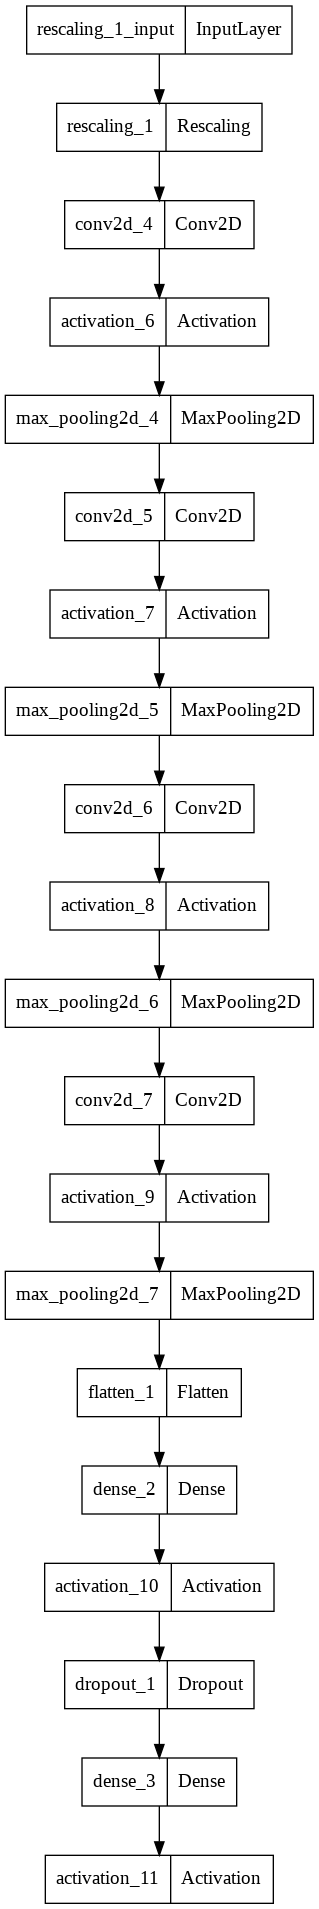

In [35]:
tf.keras.utils.plot_model(model)

In [30]:
model.save('fish_detection_model_v1.h5')